In [ ]:
!pip install ccxt

In [63]:
import ccxt
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
print (ccxt.exchanges)

['ace', 'alpaca', 'ascendex', 'bequant', 'bigone', 'binance', 'binancecoinm', 'binanceus', 'binanceusdm', 'bingx', 'bit2c', 'bitbank', 'bitbay', 'bitbns', 'bitcoincom', 'bitfinex', 'bitfinex2', 'bitflyer', 'bitforex', 'bitget', 'bithumb', 'bitmart', 'bitmex', 'bitopro', 'bitpanda', 'bitrue', 'bitso', 'bitstamp', 'bitstamp1', 'bittrex', 'bitvavo', 'bl3p', 'blockchaincom', 'btcalpha', 'btcbox', 'btcmarkets', 'btctradeua', 'btcturk', 'bybit', 'cex', 'coinbase', 'coinbaseprime', 'coinbasepro', 'coincheck', 'coinex', 'coinfalcon', 'coinmate', 'coinone', 'coinsph', 'coinspot', 'cryptocom', 'currencycom', 'delta', 'deribit', 'digifinex', 'exmo', 'fmfwio', 'gate', 'gateio', 'gemini', 'hitbtc', 'hitbtc3', 'hollaex', 'huobi', 'huobijp', 'huobipro', 'idex', 'independentreserve', 'indodax', 'kraken', 'krakenfutures', 'kucoin', 'kucoinfutures', 'kuna', 'latoken', 'lbank', 'lbank2', 'luno', 'lykke', 'mercado', 'mexc', 'mexc3', 'ndax', 'novadax', 'oceanex', 'okcoin', 'okex', 'okex5', 'okx', 'paymium'

In [41]:
exchange = ccxt.binance()
ticker = exchange.fetch_ticker(symbol)

current_price = ticker['ask']

print(f'The current price of BTC is {current_price} USDT')

The current price of BTC is 27961.09 USDT


OHLC Data of last 24 hours

In [62]:
yesterday_time = int((datetime.utcnow() - timedelta(hours=24)).timestamp()) * 1000 # time 24 hours ago in milliseconds
since_time = int((datetime.utcnow() - timedelta(minutes=440)).timestamp()) * 1000 # time since 1000 minutes from 24 hours ago in milliseconds

OHLC = pd.DataFrame(exchange.fetch_ohlcv(
    symbol= 'BTC/USDT',
    timeframe= '1m',
    since= yesterday_time,
    limit= 1000 # max datapoints per call

), columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
)
OHLC_data_since = pd.DataFrame(exchange.fetch_ohlcv(
    symbol= 'BTC/USDT',
    timeframe= '1m',
    since= since_time,

), columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume']
)

combined_OHLC = pd.concat([OHLC, OHLC_data_since], ignore_index=True)


combined_OHLC['Time'] = [datetime.fromtimestamp(float(time)/1000) for time in combined_OHLC['Time']]
combined_OHLC.set_index('Time', inplace=True)

combined_OHLC

,Open,High,Low,Close,Volume
Time,,,,,
2023-10-07 01:19:00,27912.62,27912.63,27912.62,27912.63,2.87479
2023-10-07 01:20:00,27912.62,27912.63,27907.63,27907.63,6.84438
2023-10-07 01:21:00,27907.63,27907.64,27906.05,27906.05,5.43480
2023-10-07 01:22:00,27906.05,27906.06,27905.07,27905.07,1.41042
2023-10-07 01:23:00,27905.08,27905.08,27903.67,27903.67,2.05875
...,...,...,...,...,...
2023-10-07 21:14:00,27959.77,27959.77,27954.36,27954.37,4.50392
2023-10-07 21:15:00,27954.37,27954.37,27954.23,27954.24,3.02311
2023-10-07 21:16:00,27954.23,27954.24,27954.23,27954.23,3.40664


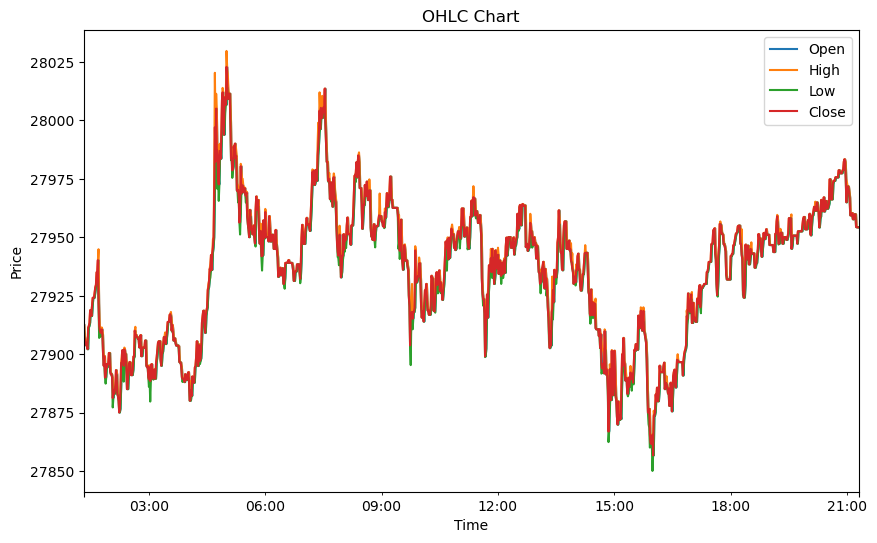

In [65]:
combined_OHLC[['Open', 'High', 'Low', 'Close']].plot(style='-', figsize=(10, 6))

# Set labels and title
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('OHLC Chart')

# Show the plot
plt.show()
